In [1]:
import numpy as np

class Agent:

    def __init__(self, player_number, eps=0.1, alpha=0.2):
        self.eps = eps
        self.alpha = alpha # learning rate
        self.verbose = False
        self.state_history = []
        self.state_values = []
        self.player_number = player_number

        self.points = [(0, 0)] # 1 for win, 0.5 for draw

    def reset_history(self):
        self.state_history = []

    def set_state_values(self, state_values_indexed_with_state_number):
        self.state_values = state_values_indexed_with_state_number

    def set_player_number(self, player_number):
        if player_number not in (1, 2):
            raise ValueError()
        else:
            self.player_number = player_number

    def take_action(self, env):
        r = np.random.rand()
        move = None

        if r < self.eps:
            # random action
            if self.verbose:
                print("Taking a random action")

            possible_moves = self.get_possible_moves(env)

            move_id = np.random.choice(len(possible_moves))
            move = possible_moves[move_id]

        else:
            if self.verbose:
                print("Taking a greedy action")

            #choose best action
            possible_moves = self.get_possible_moves(env)

            tried_move_state_max_value = -999
            tried_move_with_max_state_value = None
            for possible_move in possible_moves:
                # get value of this state number
                tried_move_state_value = self.get_move_state_value(env, possible_move)

                if tried_move_state_value > tried_move_state_max_value:
                    tried_move_with_max_state_value = possible_move
                    tried_move_state_max_value = tried_move_state_value

            move = tried_move_with_max_state_value

        #do the move eventually
        env.board[move] = self.player_number
        # env.print_array(env.board)

    def get_possible_moves(self, env):
        possible_moves = []
        for i in range(env.rows):
            for j in range(env.columns):
                if env.board[i, j] == 0:
                    possible_moves.append((i, j))
        return possible_moves

    def update_state_history(self, state_number):
        self.state_history.append(state_number)

    def update_state_values(self, env):
        # 1 - agent won | 0 - otherwise
        reward = env.reward(self.player_number)
        target = reward

        #start updating with the latest state
        for previous_state in reversed(self.state_history):
            # V(prev_state) = V(prev_state) + alpha*(V(next_state) - V(prev_state))
            previous_state_value = self.state_values[previous_state] + self.alpha*(target - self.state_values[previous_state])
            self.state_values[previous_state] = previous_state_value
            target = previous_state_value

        # when we are done updating state values
        self.reset_history()

    def get_move_state_value(self, env, move):
        # make a move
        env.board[move] = self.player_number

        move_state_number = env.get_state_number(env.board)
        move_state_value = self.state_values[move_state_number]

        # redo move
        env.board[move] = 0

        return move_state_value

    def get_possible_move_state_values_board(self, env, change_player_numbers_to_symbols=True):
        copied_board = env.board.astype(str)

        if change_player_numbers_to_symbols:
            copied_board[ copied_board == '1'] = 'x'
            copied_board[copied_board == '2'] = 'o'

        possible_moves = self.get_possible_moves(env)
        for possible_move in possible_moves:
            copied_board[possible_move[0], possible_move[1]] = self.get_move_state_value(env, possible_move)

        return copied_board


In [2]:
class Environment:

    def __init__(self, rows, columns):
        self.rows = rows
        self.columns = columns
        self.board = np.zeros((rows, columns), int)
        self.winner = None
        self.game_ended = False
        self.draw = False
        self.num_states = 3**(rows*columns)
        self.state_number_winner_ended_triple = []

    def clear_board(self):
        self.board.fill(0)
        self.winner = None
        self.game_ended = False
        self.draw = False

    def reward(self, player_symbol):
        if not self.check_game_ended():
            return 0

        return 1 if self.winner == player_symbol else 0

    def is_empty(self, i, j):
        return self.board[i, j] == 0

    def get_state_number(self, board):
        power = 0
        state_number = 0
        for row in range(len(board)):
            for column in range(len(board[0])):
                current_field_value = board[row][column] # 0 1 2
                state_number += 3**power * current_field_value
                power += 1

        return state_number

    #something's seriously wrong with this function
    def get_all_possible_states(self, board, player_turn, visited_state_numbers):
        # initial state
        states = [(self.get_state_number(board), self.game_ended, self.winner)]

        possible_moves = []
        for i in range(self.rows):
            for j in range(self.columns):
                if board[i, j] not in (1, 2) and not self.check_game_ended(force_recalculate=True):
                    previous_state = self.board[i, j]
                    self.board[i, j] = player_turn
                    next_move_state_number = self.get_state_number(self.board)

                    if next_move_state_number not in visited_state_numbers:
                        visited_state_numbers.append(next_move_state_number)
                        possible_moves.append((i, j))

                    self.board[i, j] = previous_state

        for move in possible_moves:
            previous_state = self.board[move]
            self.board[move] = player_turn
            self.check_game_ended(force_recalculate=True)

            states.append((self.get_state_number(self.board), self.game_ended, self.winner))

            if player_turn == 1:
                player_turn = 2
            else:
                player_turn = 1

            board_copy = board.copy()
            board_copy[move] = player_turn

            self.board[move] = previous_state

            states += self.get_all_possible_states(board_copy, player_turn, visited_state_numbers)

        return states

    def check_game_ended(self, force_recalculate=False):
        if not force_recalculate:
            return self.game_ended

        # assume that:
        self.game_ended = False
        self.draw = False
        self.winner = None

        # set fields / check if assumptions were right
        self._game_ended_row_check()
        self._game_ended_column_check()
        self._game_ended_diagonal_check()
        self._draw_check()

        return self.game_ended

    def _draw_check(self):
        if np.all(self.board != 0):
            self.draw = True
            self.game_ended = True
            self.winner = None

    def _game_ended_diagonal_check(self):
        for player_number in (1, 2):
            #left to right
            for row in range(self.rows - 2):
                in_a_diagonal_count = 0
                for column in range(self.columns - 2):

                    if self.board[row, column] == player_number:
                        in_a_diagonal_count += 1
                    if self.board[row + 1, column + 1] == player_number:
                        in_a_diagonal_count += 1
                    if self.board[row + 2, column + 2] == player_number:
                        in_a_diagonal_count += 1

                    if in_a_diagonal_count == 3:
                        self.winner = player_number
                        self.game_ended = True

                    in_a_diagonal_count = 0

            # right to left
            for row in range(self.rows - 2):
                in_a_diagonal_count = 0
                for column in range(2, self.columns):

                    if self.board[row, column] == player_number:
                        in_a_diagonal_count += 1
                    if self.board[row + 1, column - 1] == player_number:
                        in_a_diagonal_count += 1
                    if self.board[row + 2, column - 2] == player_number:
                        in_a_diagonal_count += 1

                    if in_a_diagonal_count == 3:
                        self.winner = player_number
                        self.game_ended = True

                    in_a_diagonal_count = 0

        return self.game_ended

    def _game_ended_row_check(self):
        for player_number in (1, 2):
            for row in range(self.rows):
                for column in range(self.columns - 2):
                    if self.board[row, column] == player_number and self.board[row, column + 1] == player_number and self.board[row, column + 2] == player_number:
                        self.winner = player_number
                        self.game_ended = True

        return self.game_ended

    def _game_ended_column_check(self):
        for player_number in (1, 2):
            for column in range(self.columns):

                for row in range(self.rows - 2):
                    if self.board[row, column] == player_number and self.board[row + 1, column] == player_number and self.board[row + 2, column] == player_number:
                        self.winner = player_number
                        self.game_ended = True

        return self.game_ended

    def is_draw(self):
        return np.all(self.board != 0)

    def set_x(self, row, column):
        self.board[row, column] = 1

    def set_o(self, row, column):
        self.board[row, column] = 2

    def get_board_from_state_number(self, state_number, print_board=False):
        board = np.zeros((self.rows, self.columns), int)
        for row in range(self.rows, 0, -1):
            for column in range(self.columns, 0, -1):
                cell_multiplier = 3 ** ((row - 1) * self.columns + column - 1)
                if 2 * cell_multiplier <= state_number:
                    board[row - 1, column - 1] = 2
                    state_number = state_number - 2 * cell_multiplier
                elif cell_multiplier <= state_number:
                    board[row - 1, column - 1] = 1
                    state_number = state_number - cell_multiplier
                else:
                    board[row - 1, column - 1] = 0

        if print_board:
            self.print_array(board)

        return board

    def print_array(self, board):
        for row in range(self.rows):
            for column in range(self.columns):
                value = board[row][column]
                if value == 0:
                    print('.', end=" ")
                elif value == 1:
                    print('x', end=" ")
                elif value == 2:
                    print('o', end=" ")
            print()

In [3]:
class Human:
    def __init__(self):
        pass

    def set_symbol(self, player_number):
        self.player_number = player_number

    def take_action(self, env):
        while True:
            # break if we make a legal move
            move = input("Enter coordinates i,j for your next move (i,j=0..2): ")
            i, j = move.split(',')
            i = int(i)
            j = int(j)
            if env.is_empty(i, j):
                env.board[i, j] = 1 if self.player_number == 'x' else 2
                break

    def update(self, env):
        pass

    def update_state_values(self, s):
        pass

    def update_state_history(self, env):
        pass

state 1 out of 19683. 0.0 % done
state 501 out of 19683. 2.5 % done
state 1001 out of 19683. 5.1 % done
state 1501 out of 19683. 7.6 % done
state 2001 out of 19683. 10.2 % done
state 2501 out of 19683. 12.7 % done
state 3001 out of 19683. 15.2 % done
state 3501 out of 19683. 17.8 % done
state 4001 out of 19683. 20.3 % done
state 4501 out of 19683. 22.9 % done
state 5001 out of 19683. 25.4 % done
state 5501 out of 19683. 27.9 % done
state 6001 out of 19683. 30.5 % done
state 6501 out of 19683. 33.0 % done
state 7001 out of 19683. 35.6 % done
state 7501 out of 19683. 38.1 % done
state 8001 out of 19683. 40.6 % done
state 8501 out of 19683. 43.2 % done
state 9001 out of 19683. 45.7 % done
state 9501 out of 19683. 48.3 % done
state 10001 out of 19683. 50.8 % done
state 10501 out of 19683. 53.4 % done
state 11001 out of 19683. 55.9 % done
state 11501 out of 19683. 58.4 % done
state 12001 out of 19683. 61.0 % done
state 12501 out of 19683. 63.5 % done
state 13001 out of 19683. 66.1 % done
st

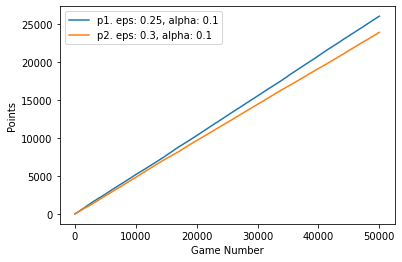

p2: 
 [['0.307742639' '0.303517614' '0.300881935']
 ['0.310887533' '0.674256272' '0.286152730']
 ['0.312834068' '0.243462579' '0.320031817']]
p1: 
 [['0.334141065' '0.361842852' '0.386219880']
 ['0.334086505' '0.696151380' '0.325408247']
 ['0.286024432' '0.290794396' '0.309891782']]
. . . 
. . . 
. . . 
Enter coordinates i,j for your next move (i,j=0..2): 2


ValueError: not enough values to unpack (expected 2, got 1)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# inefficient (calculation for impossible board positions) but works.


# inspired by:
# https://github.com/lazyprogrammer/machine_learning_examples/blob/master/rl/tic_tac_toe.py

def get_state_number_winner_ended_triple(env, verbose_lvl=2):
    number_winner_ended = []
    for state_number in range(env.num_states):
        board = env.get_board_from_state_number(state_number, print_board=False)
        env.board = board
        env.check_game_ended(force_recalculate=True)
        number_winner_ended.append((state_number, env.game_ended, env.winner))

        if verbose_lvl == 1:
            if state_number % 500 == 0:
                print(f"state {state_number + 1} out of {env.num_states}. {round((state_number + 1) * 100 / env.num_states, 1)} % done")
        if verbose_lvl == 2:
            if state_number % 500 == 0:
                env.print_array(board)
                print(number_winner_ended[-1])

    env.state_number_winner_ended_triple = number_winner_ended

    return number_winner_ended


def initialV_x(env, state_winner_ended_triples):
    state_values = np.zeros(env.num_states)

    for state, winner, ended in state_winner_ended_triples:
        if ended:
            if winner == 1:
                state_value = 1
            else:
                state_value = 0.5
            state_values[state] = state_value

        state_value = 0.5
        state_values[state] = state_value

    return state_values


def initialV_o(env, state_winner_ended_triples):
    state_values = np.zeros(env.num_states)

    for state, winner, ended in state_winner_ended_triples:
        if ended:
            if winner == 0:
                state_value = 1
            else:
                state_value = 0.5

            state_values[state] = state_value

        state_value = 0.5
        state_values[state] = state_value

    return state_values


def play_game(p1, p2, env, draw=False, draw_state_values=False):
    # choose player starting the game randomly
    current_player = None
    if np.random.rand() < 0.5:
        current_player = p1
    else:
        current_player = p2

    while not env.check_game_ended(force_recalculate=True):
        if current_player == p1:
            current_player = p2
        else:
            current_player = p1

        if draw:
            env.print_array(env.board)
            if draw_state_values and isinstance(current_player, Agent):
                print('\n Computer possible move state values:')
                print(current_player.get_possible_move_state_values_board(env))
                print('\n -------------------------------------')

        # current player makes a move
        current_player.take_action(env)

        # update state history
        state = env.get_state_number(env.board)
        p1.update_state_history(state)
        p2.update_state_history(state)

    game_nr = len(p2.points)
    if isinstance(p1, Agent):
        if env.winner == p1.player_number:
            p1.points.append((game_nr, p1.points[-1][1] + 1))
        elif env.winner == p2.player_number:
            p1.points.append((game_nr, p1.points[-1][1]))
        else:
            p1.points.append((game_nr, p1.points[-1][1] + 0.5))

    if isinstance(p2, Agent):
        if env.winner == p2.player_number:
            p2.points.append((game_nr, p2.points[-1][1] + 1))
        elif env.winner == p1.player_number:
            p2.points.append((game_nr, p2.points[-1][1]))
        else:
            p2.points.append((game_nr, p2.points[game_nr - 1][1] + 0.5))

    if env.winner == p1.player_number and isinstance(p1, Human) or env.winner == p2.player_number and isinstance(p2, Human):
        print('Ghrrr! Watch your back human! Next time I will triumph! \n')

    if draw:
        env.print_array(env.board)

    # update the value function
    p1.update_state_values(env)
    p2.update_state_values(env)

    # finally
    env.clear_board()

# ----------------------------------------------------
env = Environment(3, 3) # other sizes doesn't really make sense!

p1 = Agent(player_number=1)  # player x
p1.eps = 0.25
p1.alpha = 0.1

p2 = Agent(player_number=2)  # player o
p2.eps = 0.3
p2.alpha = 0.1

# set initial state values for both players
state_winner_triples = get_state_number_winner_ended_triple(env, verbose_lvl=1)
env.state_number_winner_ended_triple = state_winner_triples

Vx = initialV_x(env, state_winner_triples)
p1.set_state_values(Vx)

Vo = initialV_o(env, state_winner_triples)
p2.set_state_values(Vo)

number_of_games_to_be_played = 50000
for game_nr in range(number_of_games_to_be_played):
    if game_nr % 100 == 0:
        print(f'game number: {game_nr}')
    play_game(p1, p2, env, draw=False)

game_nr1, points1 = zip(*p1.points)
game_nr2, points2 = zip(*p2.points)

plt.plot(game_nr1, points1, label=f'p1. eps: {p1.eps}, alpha: {p1.alpha}')
plt.plot(game_nr2, points2, label=f'p2. eps: {p2.eps}, alpha: {p2.alpha}')
plt.legend()
plt.xlabel('Game Number')
plt.ylabel('Points')
plt.show()

# Print initial state values for both trained computer-agents
print('p2: \n', p2.get_possible_move_state_values_board(env))
print('p1: \n', p1.get_possible_move_state_values_board(env))

human = Human()
human.set_symbol(2)
while True:
    # show if greedy action or exploration chosen?
    p1.verbose = True

    p1.eps=0 # don't explore!

    play_game(human, p1, env, draw=True, draw_state_values=True)

    answer = input("Dare to challenge me you carbon-based life form? [y/n]: ")
    if answer and answer.lower()[0] == 'n':
        break